 <div align='center' ><font size='5'>CQF EXAM Three</font></div>  
 <br/>

<center>May, 2023</center>  

 <br/>
<center>January Cohort</center>  
 <br/>

<center>Wei Wei</center>

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Import VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Selection using RFE
from sklearn.feature_selection import RFECV, RFE

# Import SHAP
import shap

import cufflinks as cf
cf.set_config_file(offline=True, theme='pearl')

import plotly.graph_objects as go

# Preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from sklearn.feature_selection import f_regression, SelectKBest, SelectPercentile

# Classifier
from sklearn.svm import LinearSVC, SVC

# Metrics
from sklearn.metrics import (
    precision_recall_curve, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay,
    accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, auc,
    classification_report, confusion_matrix
)

# Machine info & package version
from watermark import watermark
%load_ext watermark
%watermark -a "Wei Wei" -u -d -v -m -iv

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/anaconda3/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100

Author: Wei Wei

Last updated: 2023-05-29

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

cufflinks : 0.17.3
matplotlib: 3.3.4
numpy     : 1.23.0
yfinance  : 0.2.9
shap      : 0.41.0
plotly    : 5.9.0
pandas    : 1.5.3



#  Data Pre-processing
## Data Downloading & Cleaning

In [2]:
df = yf.download(tickers = 'spy', start="2020-05-21", end="2023-05-21", interval='1d')
df.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-21 00:00:00-04:00,296.790009,297.670013,293.690002,294.880005,281.683777,78293900
2020-05-22 00:00:00-04:00,294.570007,295.630005,293.220001,295.440002,282.218658,63958200
2020-05-26 00:00:00-04:00,301.929993,302.190002,295.459991,299.079987,285.695740,88951400
2020-05-27 00:00:00-04:00,302.119995,303.570007,296.869995,303.529999,289.946655,104817400
2020-05-28 00:00:00-04:00,304.649994,306.839996,302.239990,302.970001,289.411682,90405200


In [3]:
# Check for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,755.000000,755.000000,755.000000,755.000000,755.000000,7.550000e+02
mean,399.062092,401.664808,396.203470,399.122120,390.575136,8.268376e+07
std,41.664417,41.637317,41.698080,41.689761,42.730914,3.095025e+07
min,294.570007,295.630005,293.220001,294.880005,281.683777,2.645790e+07
25%,375.755005,378.774994,371.845001,375.035004,367.537628,5.989910e+07
50%,401.609985,404.160004,397.640015,400.630005,396.984894,7.643150e+07
75%,431.264999,434.055008,427.139999,430.675003,421.855194,9.742345e+07
max,479.220001,479.980011,476.059998,477.709991,468.296417,2.517839e+08


<AxesSubplot:xlabel='Date'>

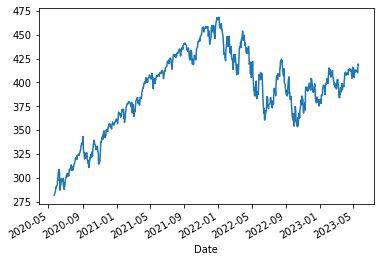

In [5]:
df['Adj Close'].plot()

## Feartures Construction

In [6]:
# Predictors
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low
df['Log_Return'] = np.log(df['Adj Close']).diff().dropna()

df['Sign0'] = np.where(df['Log_Return']>0,1,0)

df['Pass_Returns_2'] = df['Log_Return'].diff(2)
df['Pass_Returns_3'] = df['Log_Return'].diff(3)
df['Pass_Returns_5'] = df['Log_Return'].diff(5)

# Momentum
df['Momentum_2'] = df['Adj Close'].diff(2)
df['Momentum_3'] = df['Adj Close'].diff(3)
df['Momentum_5'] = df['Adj Close'].diff(5)

# SMA
df['SMA_2'] = df['Adj Close'].rolling(2).mean()
df['SMA_3'] = df['Adj Close'].rolling(3).mean()
df['SMA_5'] = df['Adj Close'].rolling(5).mean()


# EMA（Exponential Moving Average）
alpha = 2/(len(df) + 1)
df['EMA'] = df['Adj Close'].ewm(alpha = alpha, adjust = False).mean()
pd.Series(df.Sign0).value_counts()

1    400
0    355
Name: Sign0, dtype: int64

<AxesSubplot:xlabel='Date'>

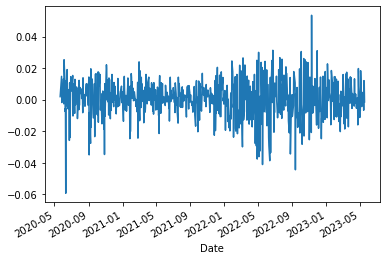

In [7]:
df['Log_Return'].plot()

In [8]:
df_Features = df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
#The sign for the next day
df_Features['Sign0'] = df_Features['Sign0'].shift(-1)
df_Features=df_Features.dropna()
df_Features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2020-06-01 00:00:00-04:00 to 2023-05-18 00:00:00-04:00
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close       748 non-null    float64
 1   O-C             748 non-null    float64
 2   H-L             748 non-null    float64
 3   Log_Return      748 non-null    float64
 4   Sign0           748 non-null    float64
 5   Pass_Returns_2  748 non-null    float64
 6   Pass_Returns_3  748 non-null    float64
 7   Pass_Returns_5  748 non-null    float64
 8   Momentum_2      748 non-null    float64
 9   Momentum_3      748 non-null    float64
 10  Momentum_5      748 non-null    float64
 11  SMA_2           748 non-null    float64
 12  SMA_3           748 non-null    float64
 13  SMA_5           748 non-null    float64
 14  EMA             748 non-null    float64
dtypes: float64(15)
memory usage: 93.5 KB


In [9]:
df_Features.drop(['Sign0','Adj Close'], axis=1).corr().iplot(kind='heatmap', title="Correlation Matrix", colorscale="blues")

### Extremely Value processing
* Finding the mean value of the log-return distribution (i.e. make sure that the threshold would not excess the mean)
* Search for the optimal threshold to statify two conditopn
 * (1) minimizing the number of points that need to be reclassified 
 * (2)  maximizing the training and test accuracies.

In [10]:
df['Log_Return'].agg(['mean', 'median', 'var'])

mean      0.000525
median    0.000781
var       0.000140
Name: Log_Return, dtype: float64

* The mean value of return is equal to 0.0004, so the threshold should be at least lower than 0.0004. 

In [11]:
#The histogram of log-return 5-year period
df['Log_Return'].iplot(kind='histogram', title = 'Histogram of Daily Returns', subplots=True)

In [12]:
Train_Accuracy=[]
Test_Accuracy=[]
Pos=[]
Neg=[]

for i in np.arange(0, 0.000525, 0.00001):
    df_Features['Sign1'] = np.where(df_Features['Log_Return']>i,1,0)
    df_Features['Sign1'] = df_Features['Sign1'].shift(-1)
    df_Features1=df_Features.dropna()
    X = df_Features1.loc[:,['Adj Close', 'O-C', 'H-L', 'Log_Return',  'Pass_Returns_2','Pass_Returns_3', 'Pass_Returns_5', 'Momentum_2', 'Momentum_3','Momentum_5', 'SMA_2', 'SMA_3', 'SMA_5', 'EMA']]
    y = df_Features1['Sign1']
    # Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Scale and fit the model
    model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())
    ]) 
    model.fit(X_train, y_train)

# Predicting the test dataset
    y_pred = model.predict(X_test)
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, y_pred)
    Train_Accuracy.append(acc_train)
    Test_Accuracy.append(acc_test)
    Pos.append(len( df_Features[df_Features['Sign1']==1]))
    Neg.append(len( df_Features[df_Features['Sign1']==0]))

In [13]:
Zero_scores = pd.DataFrame({'threshold': np.arange(0, 0.000525, 0.00001),
                            'Train_Accuracy': Train_Accuracy, 
                            'Test_Accuracy': Test_Accuracy,
                            'positive count':Pos,
                            'negative count':Neg})
Zero_scores.head(10)

,threshold,Train_Accuracy,Test_Accuracy,positive count,negative count
0,0.00000,0.609195,0.475556,395,352
1,0.00001,0.609195,0.475556,395,352
2,0.00002,0.609195,0.475556,395,352
3,0.00003,0.607280,0.475556,394,353
4,0.00004,0.607280,0.475556,394,353
5,0.00005,0.607280,0.475556,394,353
6,0.00006,0.607280,0.475556,394,353
7,0.00007,0.607280,0.475556,394,353
8,0.00008,0.607280,0.475556,394,353
9,0.00009,0.607280,0.475556,394,353


In [14]:
x=np.arange(0, 0.000525, 0.00001)
y1=Zero_scores['positive count']
y2=Zero_scores['negative count']
fig = go.Figure(layout={"xaxis_title": "threshold", "yaxis_title": "Values Count"})

fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines',
                    name='positive count'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='negative count'))

fig.update_layout(title='Classification Counts')

fig.show()

In [15]:
x=np.arange(0, 0.0004, 0.00001)
y1=Zero_scores['Train_Accuracy']
y2=Zero_scores['Test_Accuracy']
fig = go.Figure(layout={"xaxis_title": "threshold", "yaxis_title": "Accuracy"})

fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines',
                    name='Train_Accuracy'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='Test_Accuracy'))

fig.update_layout(title='Classification Accuracy')

fig.show()

* Considering the information presented in the two figures and the accompanying table, it is advisable to establish a threshold of 0. Log-returns that fall below this threshold should be classified as negative returns and represented by a "Sign" value of 0.

In [16]:

#set the threshold for the extreme near zero value 
# To aviod the loss the potentional gains , we have to set the thrwshold as lower as possible.
df_Features['Sign'] = np.where(df_Features['Log_Return']>0,1,0)
df_Features['Sign'] = df_Features['Sign'].shift(-1)
df_Features=df_Features.dropna()
X = df_Features.loc[:,['Adj Close', 'O-C', 'H-L', 'Log_Return',  'Pass_Returns_2','Pass_Returns_3', 'Pass_Returns_5', 'Momentum_2', 'Momentum_3','Momentum_5', 'SMA_2', 'SMA_3', 'SMA_5', 'EMA']]
y = df_Features['Sign']

### SVM results after process the extreme small value

In [17]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())
]) 
model.fit(X_train, y_train)

# Predicting the test dataset
y_pred = model.predict(X_test)
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
f0=f1_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4},f1 score:{f0:0.4}')

Train and Test Size 522, 225
Train Accuracy: 0.6092, Test Accuracy: 0.4756,f1 score:0.5816


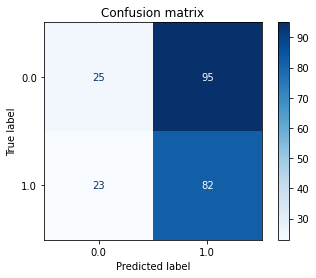

In [18]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

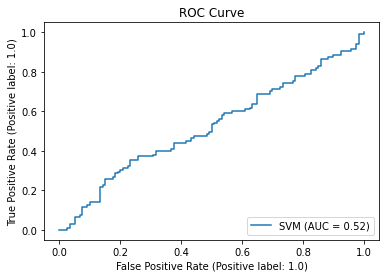

In [19]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model, 
            X_test, 
            y_test,
            name='SVM')
disp_roc.ax_.set_title('ROC Curve')
plt.show()

### Feature selection
1. Variance Inflation Factor (VIF)
2. SelectKBest
3. Recursive Feature Elimination (RFE)
4. Recursive Feature Elimination Cross validation (RFECV)
Note:Note: The last feature selection method can only be used in the SVM with a linear kernel functions.

* Method 1: VIF

In [20]:
# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())
]) 

In [21]:
# Feature scaling
scaler = MinMaxScaler()
# For each X, calculate VIF and save in dataframe
def vif(X):
# perform feature scaling
    xs = scaler.fit_transform(X)
    # subsume into a dataframe
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(xs, i) for i in range(xs.shape[1])]
    return vif

In [22]:
# List scores
vif_score=vif(X).round(2)
# Drop VIF score > 5
X_method1=X.loc[:,vif_score[vif_score["VIF Factor"]<6]['Features']]

In [23]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X_method1, y, test_size=0.3, shuffle=False)
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 522, 225


In [24]:
# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())
]) 
model.fit(X_train, y_train)
# Predicting the test dataset
y_pred = model.predict(X_test)
acc_train1 = accuracy_score(y_train, model.predict(X_train))
acc_test1 = accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train1:0.4}, Test Accuracy: {acc_test1:0.4}, f1 score:{f1:0.4}')

Train Accuracy: 0.5747, Test Accuracy: 0.5422, f1 score:0.5118


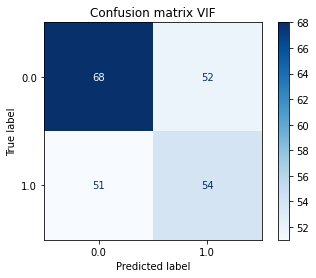

In [25]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix VIF')
plt.show()

In [26]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57       120
         1.0       0.51      0.51      0.51       105

    accuracy                           0.54       225
   macro avg       0.54      0.54      0.54       225
weighted avg       0.54      0.54      0.54       225



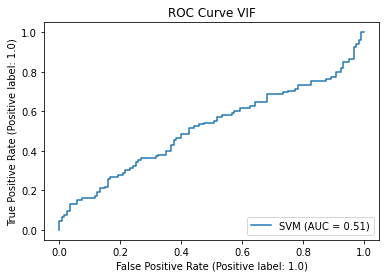

In [27]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model, 
            X_test, 
            y_test,
            name='SVM')
disp_roc.ax_.set_title('ROC Curve VIF')
plt.show()

* 2. SelectKBest

In [28]:
# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())
]) 

In [29]:
# SelectKBest
method2 = SelectKBest(f_regression, k=6)
# selector1 = SelectPercentile(f_regression, percentile=25)
# Fit the model
method2.fit(X,y)
# Show selected features
method2.get_support(indices=True)

array([ 0,  2, 10, 11, 12, 13])

In [30]:
# Iterate the score
m2_feature=pd.DataFrame({'feature':X.columns,'F-score':method2.scores_}).sort_values('F-score')
m2_feature.tail(6)

,feature,F-score
2,H-L,2.160915
12,SMA_5,4.337189
11,SMA_3,4.575778
10,SMA_2,4.700542
0,Adj Close,4.803993
13,EMA,9.362136


In [31]:
# Filter six features with highest score
X_method2 = X.loc[:,m2_feature.tail(6)['feature']]

In [32]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X_method2, y, test_size=0.3, shuffle=False)

# Scale and fit the model
model.fit(X_train, y_train)

# Predicting the test dataset
y_pred = model.predict(X_test)
acc_train2 = accuracy_score(y_train, model.predict(X_train))
acc_test2 = accuracy_score(y_test, y_pred)
f2=f1_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train2:0.4}, Test Accuracy: {acc_test2:0.4},f1 score:{f2:0.4}')

Train Accuracy: 0.5824, Test Accuracy: 0.4933,f1 score:0.5809


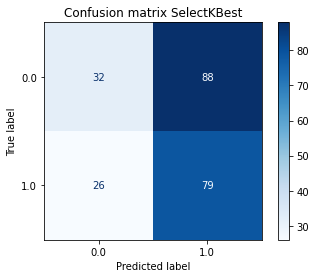

In [33]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix SelectKBest')
plt.show()

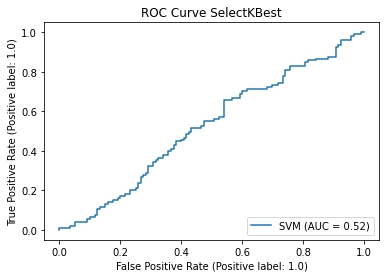

In [34]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model, 
            X_test, 
            y_test,
            name='SVM')
disp_roc.ax_.set_title('ROC Curve SelectKBest')
plt.show()

* 3: RFE
Feature ranking with recursive feature elimination (RFE). The goal is to select features by recursively
considering smaller and smaller sets of features.

In [35]:
# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())
]) 

In [36]:
# Method 3
#Only fo rthr SVM who use the kernel function is "linear"
method3 = RFE(estimator=SVC(kernel="linear"), n_features_to_select=6, step=1)
method3.fit(X,y)

RFE(estimator=SVC(kernel='linear'), n_features_to_select=6)

In [37]:
# Select Six Features
min_value = min(method3.ranking_)
col = [i for i, x in enumerate(method3.ranking_) if x == min_value]


In [38]:
# Filter selected features
X_method3 = X.iloc[:,method3.get_support(indices=True)]
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X_method3, y, test_size=0.3, shuffle=False)
model.fit(X_train, y_train)

# Predicting the test dataset
y_pred = model.predict(X_test)
acc_train3 = accuracy_score(y_train, model.predict(X_train))
acc_test3 = accuracy_score(y_test, y_pred)
f3=f1_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train3:0.4}, Test Accuracy: {acc_test3:0.4},f1 score:{f3:0.4}')

Train Accuracy: 0.5862, Test Accuracy: 0.4889,f1 score:0.6395


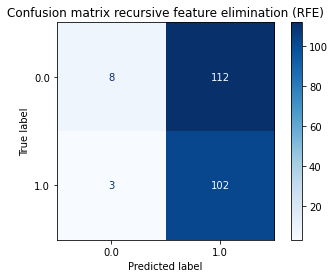

In [39]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix recursive feature elimination (RFE)')
plt.show()

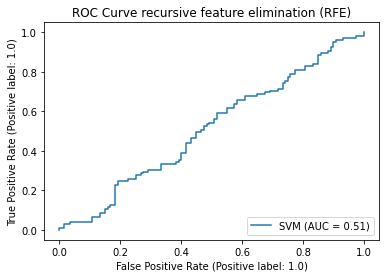

In [40]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model, 
            X_test, 
            y_test,
            name='SVM')
disp_roc.ax_.set_title('ROC Curve recursive feature elimination (RFE)')
plt.show()

* Method 4: RFECV
* A recursive feature elimination with automatic tuning of the number of features selected with cross-validation.

In [41]:
# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())
]) 

In [42]:
# Method 4
method4 = RFECV(SVC(kernel="linear"), cv=10)
method4.fit(X,y)
# Get the selected features with CV
print(f'Optimal number of features: {method4.n_features_:}')

Optimal number of features: 3


In [43]:
# Get the index of the selected features
# Filter selected features
X_method4 = X.iloc[:,method4.get_support(indices=True)]
X_train, X_test, y_train, y_test = train_test_split(X_method4, y, test_size=0.3, shuffle=False)
model.fit(X_train, y_train) 

# predict labels
y_pred = model.predict(X_test)
acc_train4 = accuracy_score(y_train, model.predict(X_train))
acc_test4 = accuracy_score(y_test, y_pred)
f4=f1_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train4:0.4}, Test Accuracy: {acc_test4:0.4},f1 score:{f4:0.4}')

Train Accuracy: 0.5843, Test Accuracy: 0.4711,f1 score:0.6222


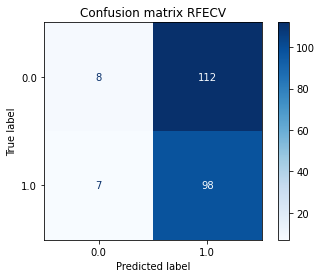

In [44]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix RFECV')
plt.show()

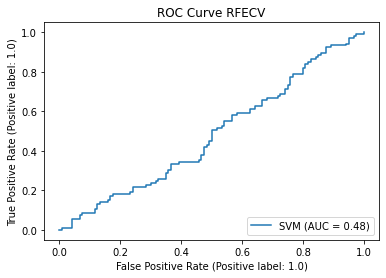

In [45]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model, 
            X_test, 
            y_test,
            name='SVM')
disp_roc.ax_.set_title('ROC Curve RFECV')
plt.show()

In [46]:
from tabulate import tabulate
table = [['non', acc_train1, acc_test, f0],
    ['VIF', acc_train1, acc_test1,f1],
    ['SelectKBest', acc_train2, acc_test2,f2],
    ['REF', acc_train3, acc_test3,f3],
    ['REFCV', acc_train4, acc_test4,f4]
]

headers = ['Feature Selection Type', 'Train Accuracy', 'Test Accuracy','f1 score']



print(tabulate(table, headers=headers))

Feature Selection Type      Train Accuracy    Test Accuracy    f1 score
------------------------  ----------------  ---------------  ----------
non                               0.574713         0.475556    0.58156
VIF                               0.574713         0.542222    0.511848
SelectKBest                       0.582375         0.493333    0.580882
REF                               0.586207         0.488889    0.639498
REFCV                             0.584291         0.471111    0.622222


* In terms of Test accuracy, the VIF method performs the best. However, considering that it is a binomial classification problem, I also take into account the f1 score. Based on the f1 score, the REFCV method outperforms the others and achieves the highest accuracy.
<br/>

* The limitation of using only the linear kernel for RFE and RFECV makes it difficult to determine the definitive best option. Therefore, I will utilize a combination of feature engineering and parameter tuning to uncover the optimal fitting and prediction model.

# Tunning parameters & Cross-sectional Validation

##  Hyper-parameter of SVM
* There are three parameters we have to consider, c is a penlty coefficients,  gamma, and kernel function.
    * C: It is the regularization parameter, C, of the error term.
    * kernel: It specifies the kernel type to be used in the algorithm. It can be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, or a callable. The default value is ‘rbf’.
    * degree: It is the degree of the polynomial kernel function (‘poly’) and is ignored by all other kernels. The default valueis 3.
    * gamma: It is the kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’. If gamma is ‘auto’, then 1/n_features will be used instead.
 | Hyper-parameter             | Range|
| :----------------: | :------------: |
| kernel |  ['linear', 'rbf', 'sigmoid','poly'] |
| C  |   np.linspace(0.1, 5, 10)|
| gamma  |   np.linspace(0.01, 0.5, 10) |
| degree |   np.arange(1, 5)|
| Feature |   [VIF','KBest','REF','REFCV']|

* I set the different range of pareametersparameters to fine-tune and discover the optimal model.

### Cross-validation for time series

In [47]:
# Cross-validation for time series
tscv = TimeSeriesSplit(n_splits=5, gap=1)

### GrideSearch


In [48]:
best_params=[]
test_score=[]
best_score=[]
parameters = {
    'classifier__kernel': ['linear', 'rbf', 'sigmoid','poly'],
    'classifier__C': np.linspace(1, 5, 10),
    'classifier__gamma': np.linspace(0.01, 1, 10),
    'classifier__degree': np.arange(1, 5)
}

grid = GridSearchCV(model, parameters, cv=tscv, scoring='accuracy', refit=True, error_score='raise')
feature=[X,X_method1,X_method2,X_method3,X_method4]
for i in feature:
    model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())]) 
    X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=0.3, shuffle=False)
    grid.fit(X_train, y_train)
    best_score .append(grid.best_score_)
    best_params.append(grid.best_params_)
    test_score.append(grid.score(X_test, y_test))
#print("The best parameters are %s with a score of %0.4f" % (best_params, best_score))

In [49]:
BEST_P=pd.DataFrame(best_params)
BEST_P['test_score']=test_score
BEST_P['best_score']=best_score
BEST_P['feature']=['non','VIF','KBest','REF','REFCV']

In [50]:
#The top-performing model for each feature selection outcome
BEST_P

,classifier__C,classifier__degree,classifier__gamma,classifier__kernel,test_score,best_score,feature
0,1.444444,1,0.45,sigmoid,0.462222,0.586207,non
1,1.888889,3,0.56,poly,0.457778,0.549425,VIF
2,4.555556,1,1.00,rbf,0.524444,0.565517,KBest
3,4.555556,1,0.78,sigmoid,0.475556,0.577011,REF
4,3.666667,1,1.00,sigmoid,0.484444,0.565517,REFCV


In [64]:
# Scale and fit the model
model_final1 = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC(C=4.555556, kernel='rbf', degree=1, gamma=1))
])

In [52]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X_method2, y, test_size=0.3, shuffle=False)

# Scale and fit the model
model_final1.fit(X_train, y_train)

# Predicting the test dataset
y_pred = model_final1.predict(X_test)
acc_train_Optimal = accuracy_score(y_train, model_final1.predict(X_train))
acc_test_Optimal = accuracy_score(y_test, y_pred)
f=f1_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train_Optimal:0.4}, Test Accuracy: {acc_test_Optimal:0.4},f1 score:{f:0.4}')

Train Accuracy: 0.5805, Test Accuracy: 0.5244,f1 score:0.5447


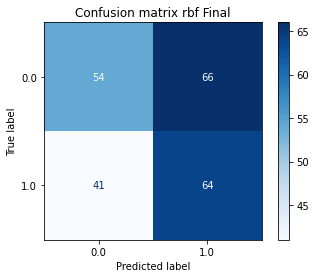

In [53]:
# Generate predictions on the test set
y_pred = model_final1.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_final1.classes_)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrix rbf Final')
plt.show()

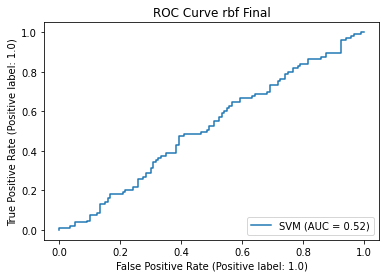

In [54]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model_final1, 
            X_test, 
            y_test,
            name='SVM')
disp_roc.ax_.set_title('ROC Curve rbf Final')
plt.show()

### RandomizedSearch

In [55]:
best_params=[]
test_score=[]
best_score=[]
for i in feature:
    model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC())]) 
    X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=0.3, shuffle=False)
    grid.fit(X_train, y_train)
    rs = RandomizedSearchCV(model, parameters, n_iter=100, scoring='accuracy', cv=tscv, verbose=0, error_score='raise')
    rs.fit(X_train, y_train)
    best_score .append(rs.best_score_)
    best_params.append(rs.best_params_)
    test_score.append( rs.score(X_test, y_test))

In [56]:
BEST_R=pd.DataFrame(best_params)
BEST_R['test_score']=test_score
BEST_R['best_score']=best_score
BEST_R['feature']=['non','VIF','SelectKBest','REF','REFCV']

In [57]:
BEST_R

,classifier__kernel,classifier__gamma,classifier__degree,classifier__C,test_score,best_score,feature
0,sigmoid,0.89,4,1.888889,0.488889,0.565517,non
1,rbf,0.78,2,5.000000,0.515556,0.544828,VIF
2,rbf,1.00,3,4.555556,0.524444,0.565517,SelectKBest
3,sigmoid,0.78,3,4.555556,0.475556,0.577011,REF
4,sigmoid,1.00,1,4.555556,0.471111,0.563218,REFCV


In [62]:
# Scale and fit the model
model_final2 = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", SVC(C=4.555556, kernel='rbf', degree=3, gamma=1))
])

In [63]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X_method2, y, test_size=0.3, shuffle=False)

# Scale and fit the model
model_final2.fit(X_train, y_train)

# Predicting the test dataset
y_pred = model_final2.predict(X_test)
acc_train_Optimal = accuracy_score(y_train, model_final2.predict(X_train))
acc_test_Optimal = accuracy_score(y_test, y_pred)
f=f1_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train_Optimal:0.4}, Test Accuracy: {acc_test_Optimal:0.4},f1 score:{f:0.4}')

Train Accuracy: 0.5805, Test Accuracy: 0.5244,f1 score:0.5447


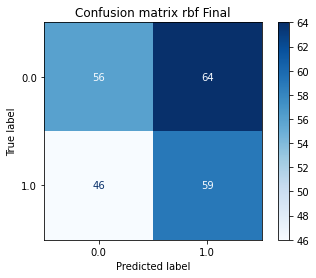

In [60]:
# Generate predictions on the test set
y_pred = model_final2.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_final2.classes_)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrix rbf Final')
plt.show()

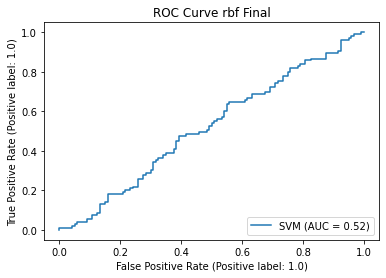

In [61]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model_final2, 
            X_test, 
            y_test,
            name='SVM')
disp_roc.ax_.set_title('ROC Curve rbf Final')
plt.show()

## Conclusion
After evaluating the optimal models obtained through distinct search methods, it was found that both methods yield identical results. The optimized parameters for the models are as follows: kernel: rbf, c=4.555, gamma=degree=1. Furthermore, the training accuracy achieved is 0.5805, the test accuracy is 0.5244, and the f1 score is 0.5447.

* document completed